## Inchkeith

Inchkeith is an island in the Firth of Forth, Scotland.
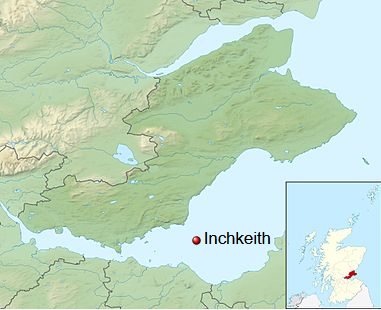

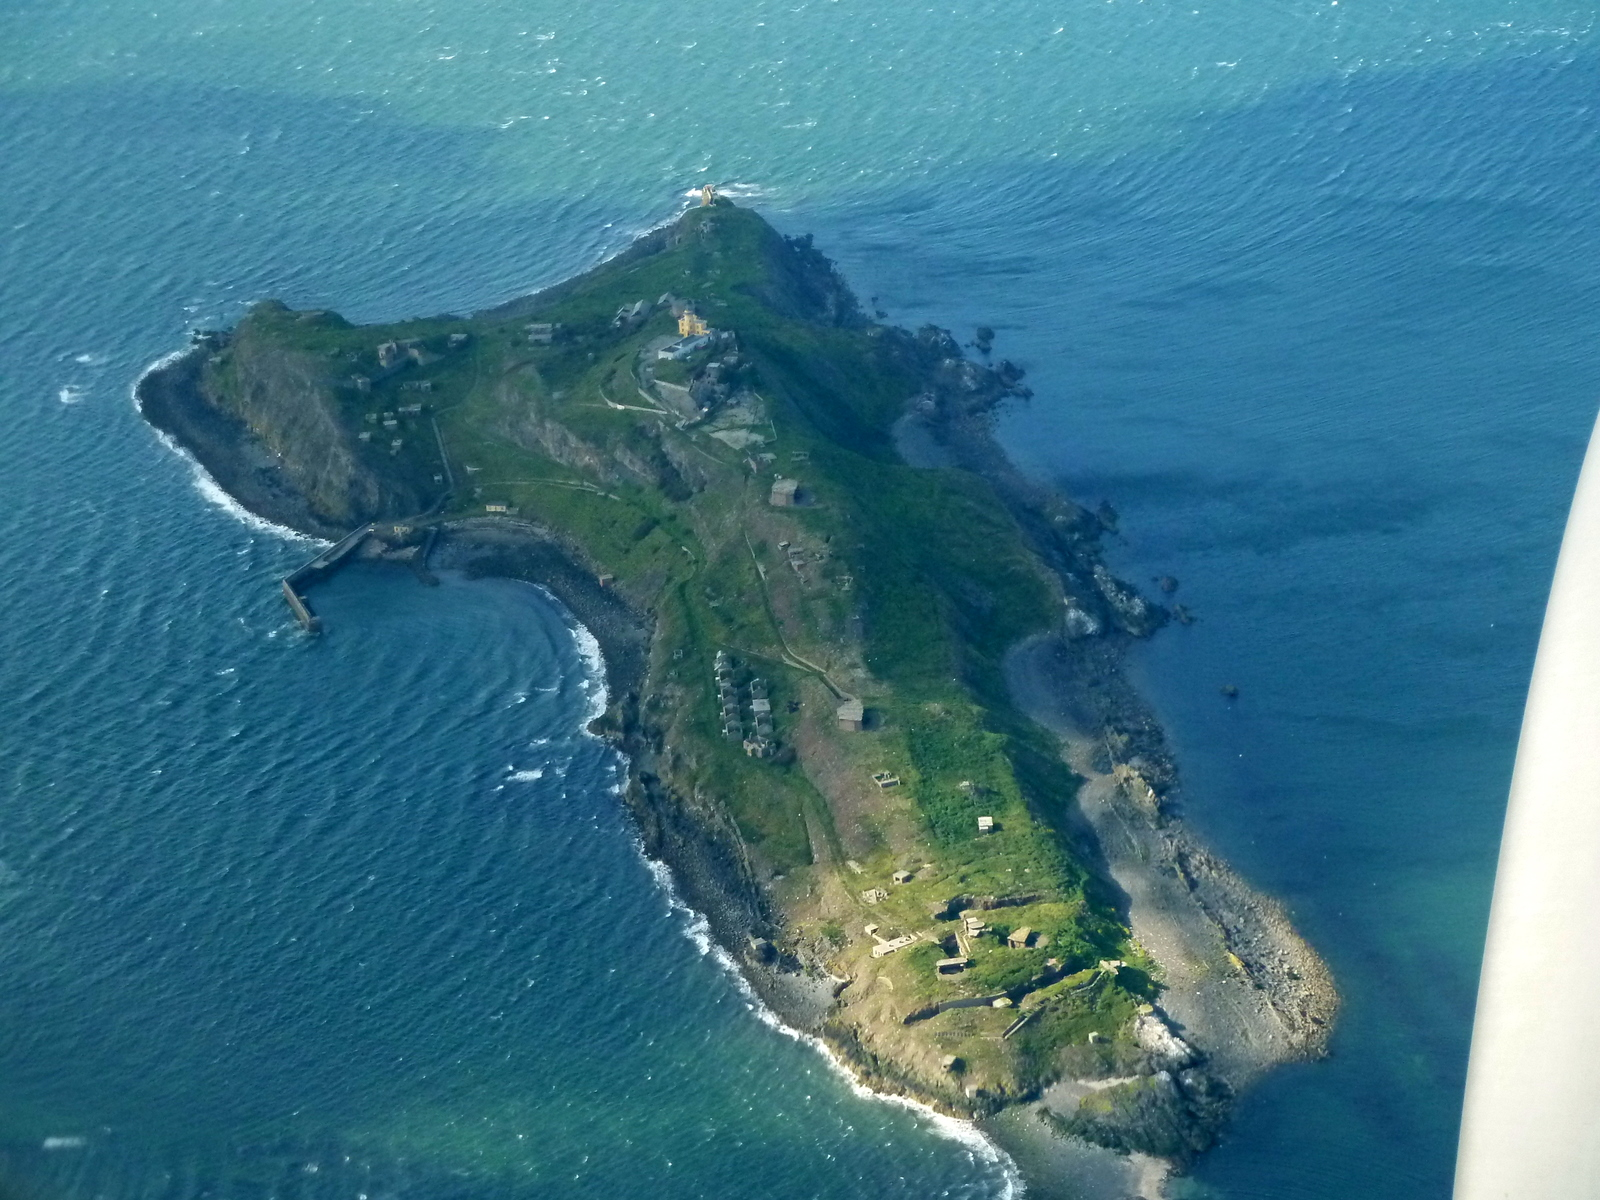

## Topography Inchkeith

In [1]:
# Install colour maps
%pip install cmocean

# Import all the necessary libraries
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import folium
import cmocean as cmo
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,10)

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Reading in the data
elevation_I = np.loadtxt('data/Inchkeith.txt')

Text(0, 0.5, 'Distance from origin in northerly direction [m]')

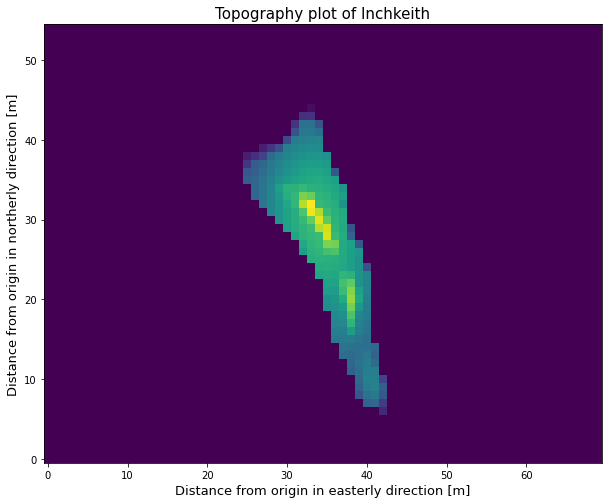

In [3]:
# Topography plot
fig, ax = plt.subplots()
plt.imshow(elevation_I[95:150, 95:165], origin='lower')
plt.title("Topography plot of Inchkeith", fontsize = 15)
plt.xlabel("Distance from origin in easterly direction [m]", fontsize = 13)
plt.ylabel("Distance from origin in northerly direction [m]", fontsize = 13)

# the island is surrounded by the sea
# is quite a pixelated plot

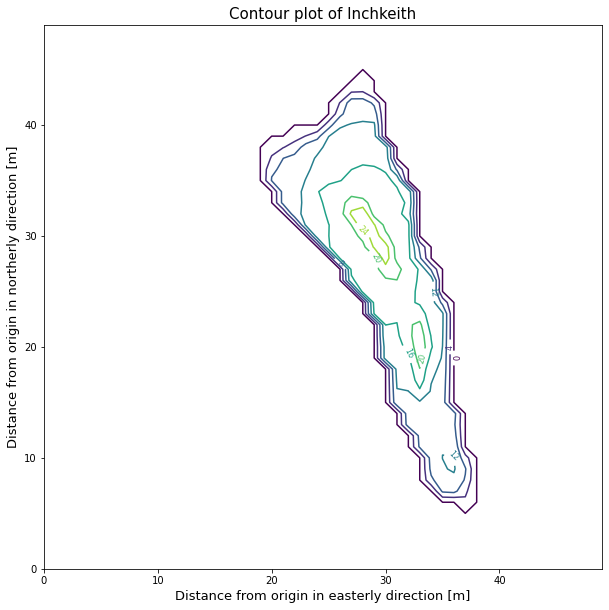

In [4]:
# Contour plot of North Berwick and Berwick Law
fig, ax = plt.subplots()

CS = ax.contour(elevation_I[95:145, 100:150])

ax.clabel(CS, inline=1, fontsize=8, fmt='%1.f')
ax.set_title('Contour plot of Inchkeith', fontsize = 15)
ax.set_xlabel("Distance from origin in easterly direction [m]", fontsize = 13)
ax.set_ylabel("Distance from origin in northerly direction [m]", fontsize = 13)


plt.show()

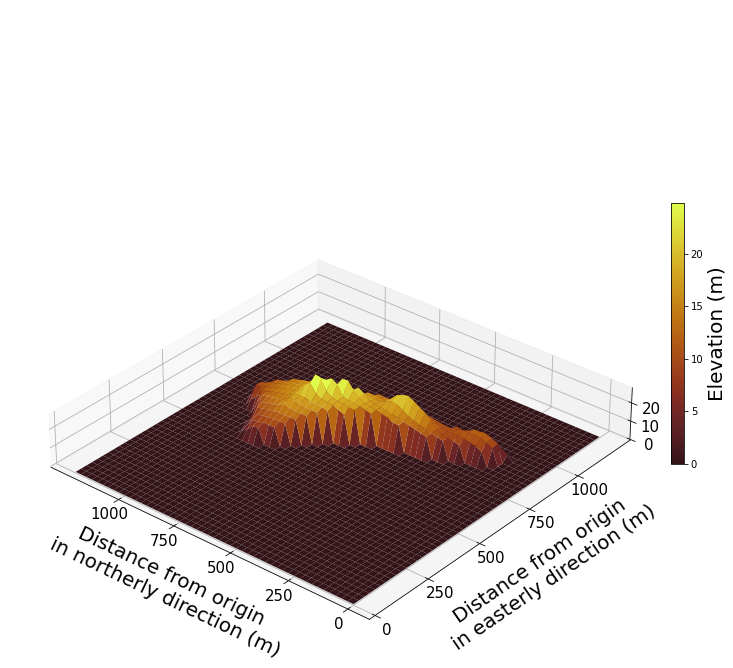

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import cmocean as cmo
# Another way of using plot_surface
# Reading in the data
elevation_I = np.loadtxt('data/Inchkeith.txt')
# Import data
fig = plt.figure(figsize=(20, 12))
ax = fig.gca(projection='3d')


# Scaling of the z-axis to make the plot less spiky and more realistic
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.2, 1]))
#ax.invert_yaxis()
# Define meshgrid and make data
elevation_sub = elevation_I[95:145, 100:150]
n=len(elevation_sub)
X = np.arange(0, n, 1)
Y = np.arange(0, n, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
B = elevation_sub[X,Y]

# Plot the surface

sur = ax.plot_surface(X, Y, B, cmap= cmo.cm.solar, rcount=50, ccount=100)
ax.view_init(azim = -230) 
fig.colorbar(sur, shrink=0.4, pad=0.01).set_label(label='Elevation (m)', size=20)


# Set axes labels
ax.set_xlabel("\n \n \nDistance from origin \nin northerly direction (m)", fontsize = 20)
ax.set_ylabel("\n \n \nDistance from origin \nin easterly direction (m)", fontsize = 20)
ax.set_xticks(np.arange(0,50,10))
ax.set_xticklabels(np.arange(0,1250,  250), fontsize=15)
ax.set_yticks(np.arange(0,50,10))
ax.set_yticklabels(np.arange(0, 1250,  250), fontsize=15)
ax.set_ylim(50, 0) 
ax.set_zticks(np.arange(0,30,10))
ax.set_zticklabels(np.arange(0, 30, 10), fontsize=15) 
fig.tight_layout()

In [6]:
## Field work suggestions
# Need to add more locations, measurement 1 is an example

# Create the basemap
loc = [56.0334, -3.1362] # Coordinates of lighthouse
m1 = folium.Map(location=loc, # Map centred at Inchkeith lighthouse
                tiles='OpenStreetMap', 
                zoom_start=17) # Zoomed in to show central Edinburgh

# Add pop-up showing the coordinates when clicking anywhere on the map
m1.add_child(folium.LatLngPopup())

# Add a marker at Argyle House (Noteable's offices)
#tooltip = 'Click me!'
#locationName = 'Measurement 1' # Text for pop-up
#workloc = [ 56.0480, -2.7166] # Coordinates of Measurement 1
#folium.Marker(workloc, popup=locationName).add_to(m1) # Add the marker to basemap
display(m1)

# do we want to give suggestions for fieldworkd?

## Wind Ichkeith

In [7]:
## Calculate wind
# Parameters
topo_file_I = 'data/Inchkeith.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file_I)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)

# Vertical wind component from continuity equation
w = np.zeros_like(wind)
dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
w[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + v[1:-1,1:-1]*dzdy

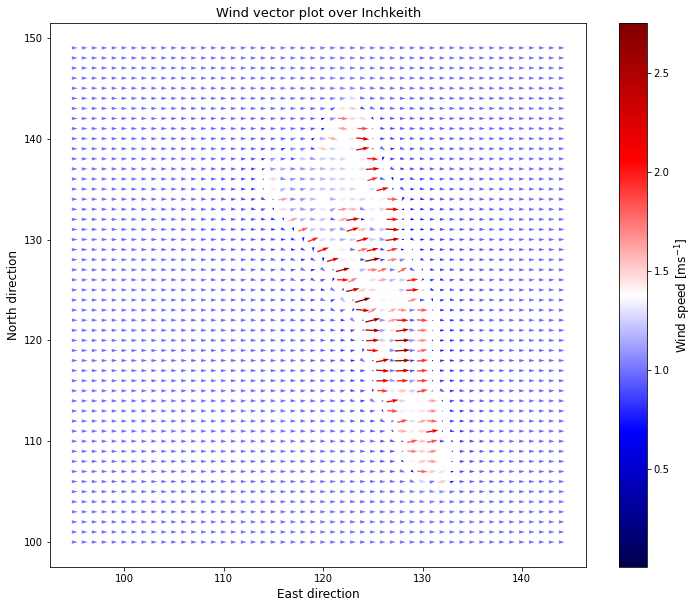

In [8]:
# Wind vector plot over hill

X = np.arange(0, 256)
Y = np.arange(0, 256)

fig, ax = plt.subplots(figsize=(12, 10))
#create quiver plot of data

q = ax.quiver(X[95:145], Y[100:150], u[95:145, 100:150], v[95:145, 100:150], wind[95:145, 100:150], cmap='seismic', pivot='mid', units='inches')

# set colourbar for the plot
cbar = fig.colorbar(q)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

ax.set_title("Wind vector plot over Inchkeith", fontsize = 13)
ax.set_xlabel("East direction", fontsize=12)
ax.set_ylabel("North direction", fontsize=12)
plt.show()

# if we use the plots from different hills next to each other
# we should couple the color bars as it is confusing otherwise

# this plot is really helpful

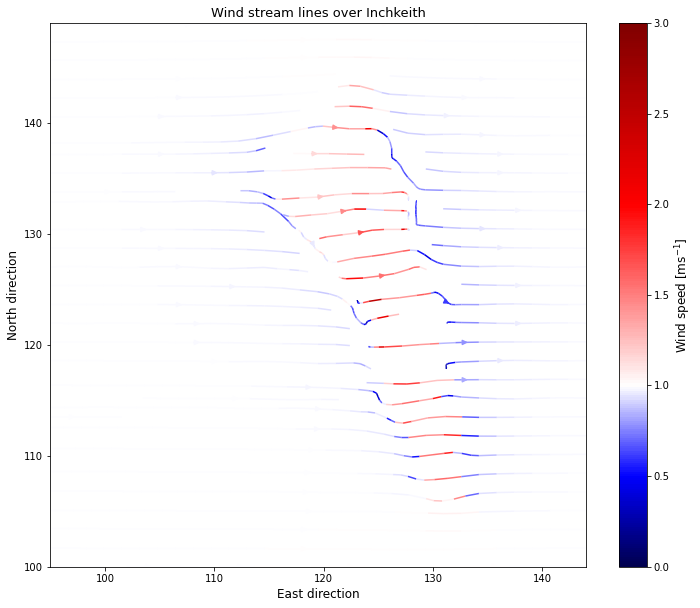

In [9]:
# Wind stream lines over hill

#create stream plot

fig, ax = plt.subplots(figsize=(12, 10))
strm = ax.streamplot(X[95:145], Y[100:150], u[95:145, 100:150], v[95:145, 100:150], color=wind[95:145, 100:150], 
                     cmap='seismic',
                     norm=matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=3))

#set colourbar according to wind speed
cbar = fig.colorbar(strm.lines)
cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 12)

ax.set_title("Wind stream lines over Inchkeith", fontsize = 13)
ax.set_xlabel("East direction", fontsize = 12)
ax.set_ylabel("North direction", fontsize = 12)

plt.show()

# this plot does not really show anything

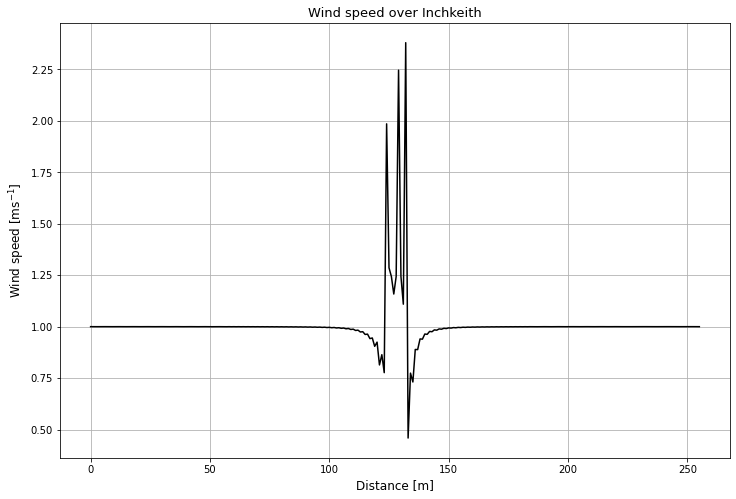

In [10]:
# Wind speed over top of hill
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(wind[125,:], c = "k")
ax.set_title("Wind speed over Inchkeith", fontsize = 13)
ax.set_xlabel("Distance [m]", fontsize = 12)
ax.set_ylabel("Wind speed [ms$^{-1}$]", fontsize = 12)
ax.grid()

## Plotting vertical component of wind

Text(0.5, 1.0, 'Vertical wind component over Inchkeith')

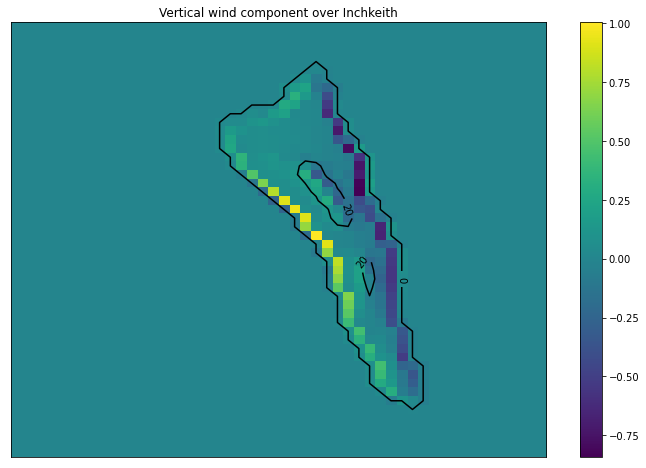

In [11]:
# Plot vertical wind component and topography for 1 km x 1 km area centred on the summit
fig, ax = plt.subplots(figsize=(12,8))

plt.imshow(w[95:145, 100:150],origin='lower', aspect='auto')  # north at the top of the image
plt.colorbar()
cs = plt.contour(z[95:145, 100:150],colors='k',levels=np.arange(0,1000,20))
plt.clabel(cs,fmt='%d')
plt.xticks([])
plt.yticks([])
plt.title("Vertical wind component over Inchkeith")

## helpful plot

## Inchkeith 3D speed plot

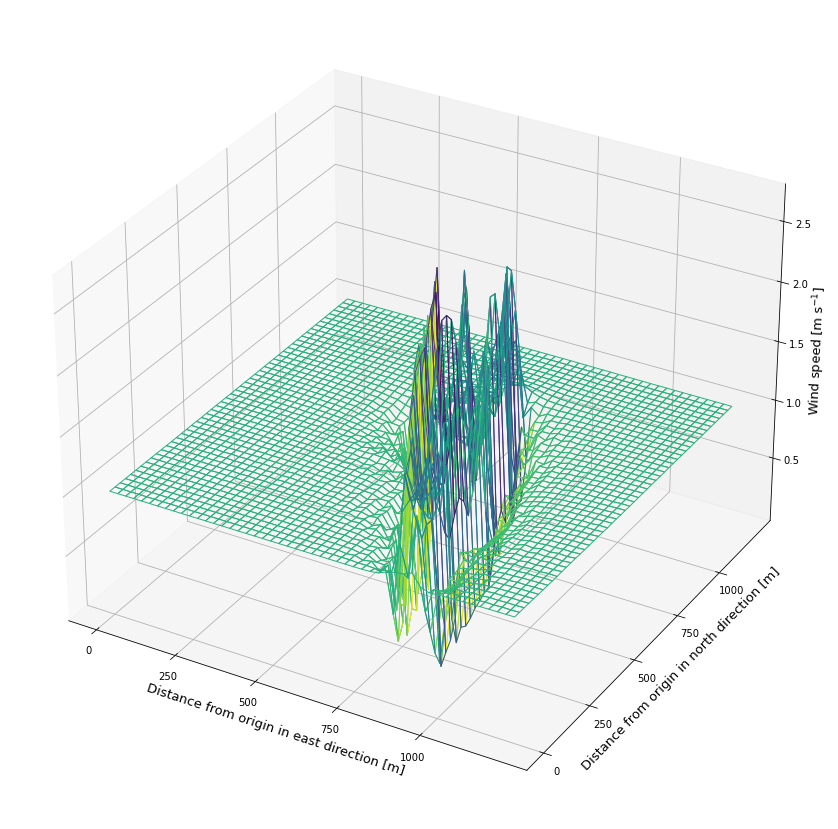

In [12]:
# Wind speed 3d plot around the hill

from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

#%matplotlib notebook
def surface_plot(data):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(0, 50)
    y = np.arange(0, 50)
    X, Y = np.meshgrid(x, y)

    # Normalize to [0,1]
    Z = data[100:150, 100:150]
    norm = plt.Normalize(Z.min(), Z.max())
    colors = cm.viridis_r(norm(Z))
    rcount, ccount, _ = colors.shape
    

    surf = ax.plot_surface(X, Y, Z, rcount=rcount, ccount=ccount,
                           facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    


    ax.set_xlabel('Distance from origin in east direction [m]', fontsize=13)
    ax.set_ylabel('Distance from origin in north direction [m]', fontsize=13)
    ax.set_zlabel('Wind speed [m s$^{-1}$]', fontsize=13)
    plt.xticks(np.arange(0, 50, step=10), labels=[0,250,500,750,1000])
    plt.yticks(np.arange(0, 50, step=10), labels=[0,250,500,750,1000])
    #ax.set_title("3D plot of wind speed around North Berwick Law", fontsize=14)
    #ax.view_init(30, 110) # change the viewing angle
    
surface_plot(wind)

# I would not include this plot as it is too messy

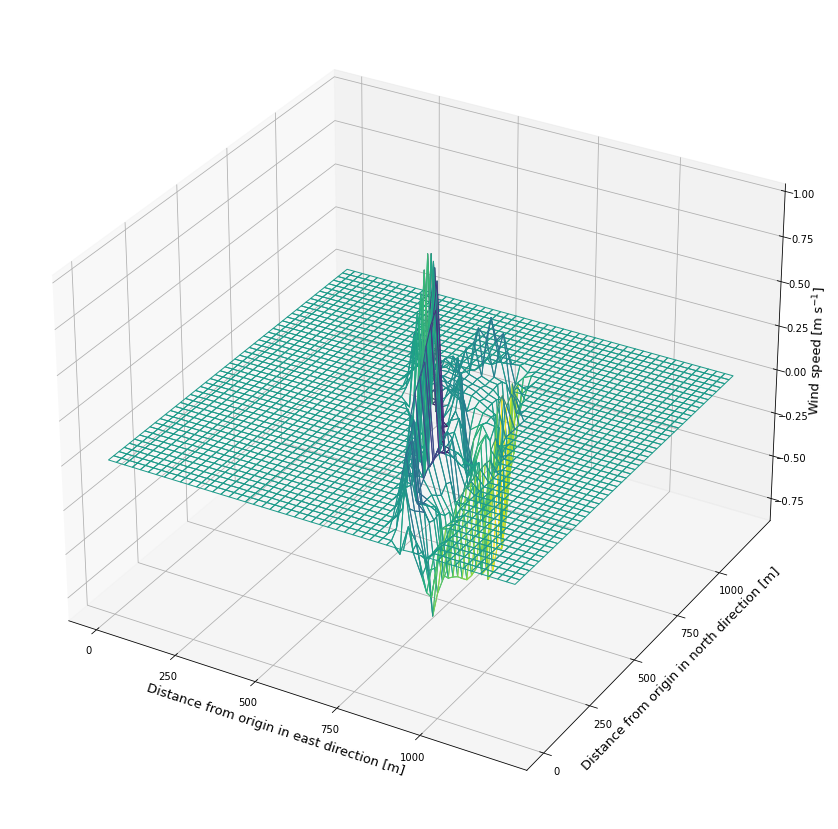

In [13]:
# 3D plot of Vertical wind speed component (w)

surface_plot(w)

## too messy

## Wind from different directions

In [14]:
## Define a function which calculates the u and v component and wind

def wind_model(n,zr):
    """
    Function to calculate the wind components and overal wind
    Input: 
    - n: n = zr.shape[0]
    - zr: Topography file to be read in
    Output: Wind components and overal wind
    """
    
    # Fourier transform
    Fz = fft2(zr)
    Fz = fftshift(Fz)
    
    # Wavenumbers and modified Bessel functions
    k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
    m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
    bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
    bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
    bu[int(n/2)] = 0
    bv[int(n/2)] = 0
    
    # Fourier components of u and v
    Fu = np.zeros_like(Fz)
    Fv = np.zeros_like(Fz)
    for i in range(n):
        for j in range(n):
            r = np.sqrt(k[j]**2 + m[i]**2)
            if r>0:
                Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
                Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]
    
    # Inverse Fourier transform
    Fu = ifftshift(Fu)
    Fv = ifftshift(Fv)
    ur = 1 + np.real(ifft2(Fu))
    vr = np.real(ifft2(Fv))
    windr = np.sqrt(ur**2 + vr**2)
    
    # Vertical wind component from continuity equation
    wr = np.zeros_like(windr)
    dzdx = (zr[1:-1,2:] - zr[1:-1,:-2])/(2*dx)
    dzdy = (zr[2:,1:-1] - zr[:-2,1:-1])/(2*dx)
    wr[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + vr[1:-1,1:-1]*dzdy
    return ur,vr,windr, wr

In [15]:
# Define a function to plot the streamplot and the contour lines

def plot_wind(u,v,wind,z,title):
    """
    Input:
    - u, v: wind components
    - wind: overall wind
    - z: topography 
    - title: title of the plot
    Output  Plots streamsplot and topography
    """
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.streamplot(x[95:145],y[100:150],u[95:145, 100:150],v[95:145, 100:150],
                   color=wind[95:145, 100:150],linewidth = 1.5, cmap='seismic',
                   norm=matplotlib.colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=3))
    plt.colorbar().set_label(label='Wind speed (m/s)', size=20)
    cs = plt.contour(x[95:145],y[100:150],z[95:145, 100:150],alpha = 0.5, colors='k')
    #plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

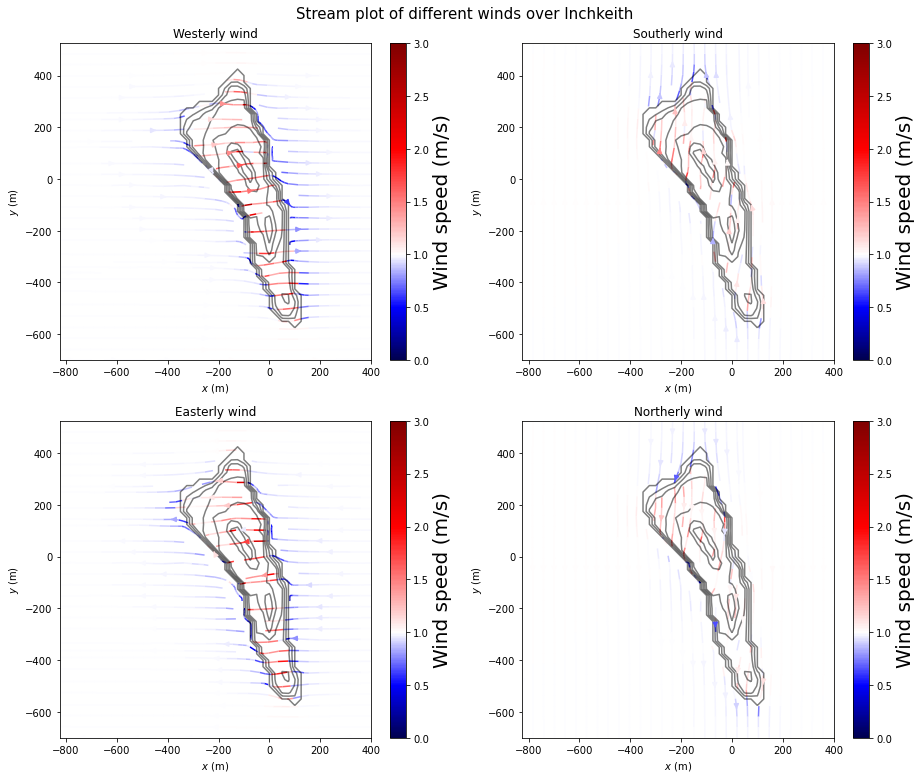

In [16]:
# Use the functions to generate 4 subplots for the different wind directions

"""
The topography is rotated 
- by 90 degrees clockwise with np.flipud(A.T), 
- by 90 degrees anticlockwise with np.fliplr(A.T),
- by 180 degrees with np.flipud(np.fliplr(A.T))

The inverse of the rotation applied to the topography has to be applied to the separate wind components.
The u and v components also have to be swapped for 90 degree rotations.
"""

plt.figure(figsize=(13, 11))

# Westerly wind
plt.subplot(221)
u, v, wind, w = wind_model(n,z)
plot_wind(u,v,wind,z,'Westerly wind')

# Southerly wind
plt.subplot(222)
zr = np.flipud(z.T)
ur, vr, windr, wr = wind_model(n,zr)
u = - np.fliplr(vr.T)
v = np.fliplr(ur.T)
wind = np.fliplr(windr.T)
plot_wind(u,v,wind,z,'Southerly wind')

# Easterly wind
plt.subplot(223)
zr = np.flipud(np.fliplr(z))
ur, vr, windr, wr = wind_model(n,zr)
u = - np.flipud(np.fliplr(ur))
v = - np.flipud(np.fliplr(vr))
wind = np.flipud(np.fliplr(windr))
plot_wind(u,v,wind,z,'Easterly wind')

# Northerly wind
plt.subplot(224)
zr = np.fliplr(z.T)
ur, vr, windr, wr = wind_model(n,zr)
u = np.flipud(vr.T)
v = - np.flipud(ur.T)
wind = np.flipud(windr.T)
plot_wind(u,v,wind,z,'Northerly wind')

plt.suptitle("Stream plot of different winds over Inchkeith", fontsize = 15)
plt.tight_layout()

In [17]:
### Define a function to plot the quiver and the contour lines

def quiver_wind(u,v,wind,z,title):
    """
    Input:
    - u, v: wind components
    - wind: overall wind
    - z: topography 
    - title: title of the plot
    Output  Plots streamsplot and topography
    """
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.quiver(x[95:145],y[100:150],u[95:145, 100:150],v[95:145, 100:150],wind[95:145, 100:150], linewidth = 30, 
               cmap='viridis_r', pivot='mid', units='inches')
    plt.colorbar()
    plt.clim(0, 3)
    cs = plt.contour(x[95:145],y[100:150],z[95:145, 100:150],alpha = 0.5, colors='k')
    #plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

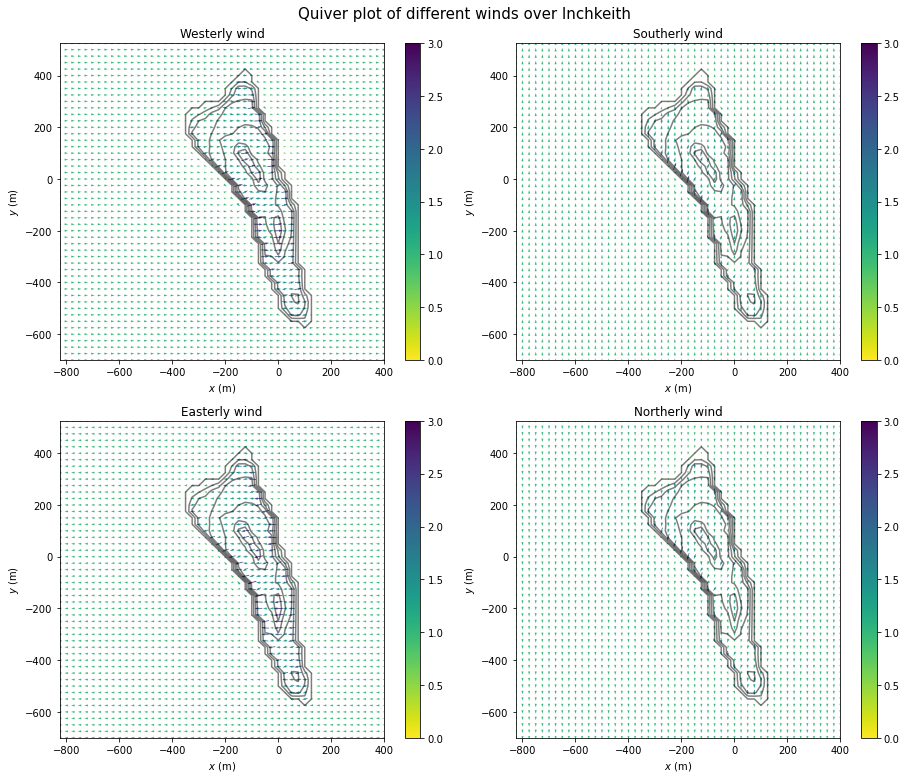

In [18]:
plt.figure(figsize=(13, 11))

# Westerly wind
plt.subplot(221)
u, v, wind, w = wind_model(n,z)
quiver_wind(u,v,wind,z,'Westerly wind')

# Southerly wind
plt.subplot(222)
zr = np.flipud(z.T)
ur, vr, windr, wr = wind_model(n,zr)
u = - np.fliplr(vr.T)
v = np.fliplr(ur.T)
wind = np.fliplr(windr.T)
quiver_wind(u,v,wind,z,'Southerly wind')

# Easterly wind
plt.subplot(223)
zr = np.flipud(np.fliplr(z))
ur, vr, windr, wr = wind_model(n,zr)
u = - np.flipud(np.fliplr(ur))
v = - np.flipud(np.fliplr(vr))
wind = np.flipud(np.fliplr(windr))
quiver_wind(u,v,wind,z,'Easterly wind')

# Northerly wind
plt.subplot(224)
zr = np.fliplr(z.T)
ur, vr, windr, wr = wind_model(n,zr)
u = np.flipud(vr.T)
v = - np.flipud(ur.T)
wind = np.flipud(windr.T)
quiver_wind(u,v,wind,z,'Northerly wind')

plt.suptitle("Quiver plot of different winds over Inchkeith", fontsize = 15)
plt.tight_layout()

In [19]:
### Define a function to plot the streamplot and the contour lines

def vertical_wind(w,z,title):
    """
    Input:
    - w: vertical wind component
    - z: topography 
    - title: title of the plot
    Output  Plots streamsplot and topography
    """
    x = np.arange(-128,128)*dx
    y = np.arange(-128,128)*dx
    plt.imshow(w[95:145, 100:150],origin='lower', aspect='auto')
    plt.colorbar()
    plt.clim(0, 3)
    cs = plt.contour(z[95:145, 100:150],colors='k',levels=np.arange(0,1000,20))
    #plt.clabel(cs,fmt='%d')
    plt.xlabel('$x$ (m)')
    plt.ylabel('$y$ (m)')
    plt.title(title)

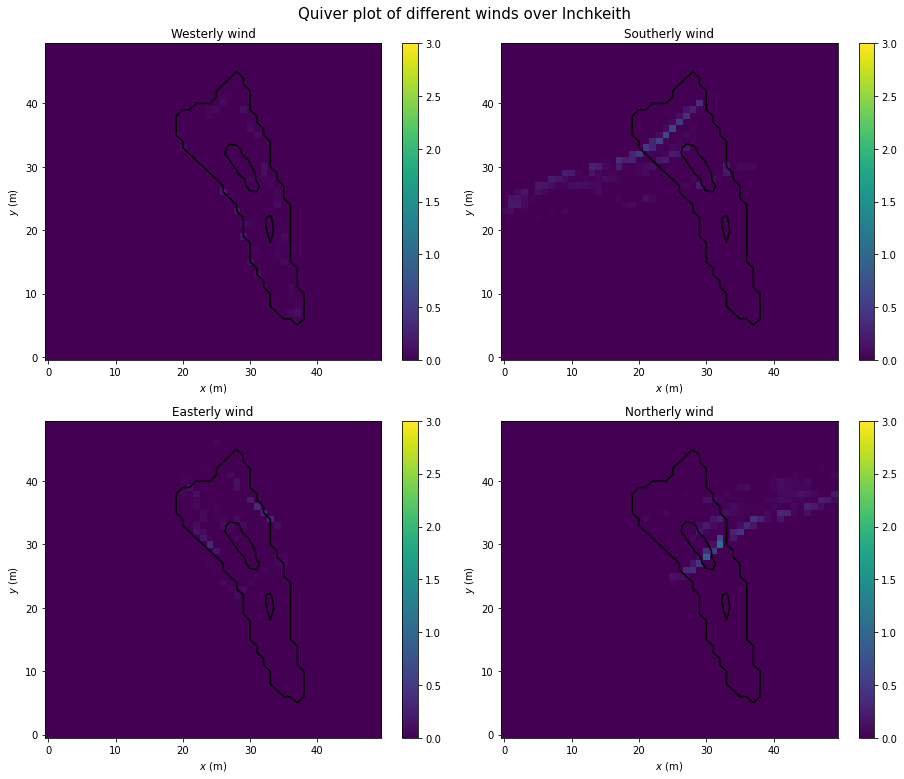

In [20]:
plt.figure(figsize=(13, 11))

# Westerly wind
plt.subplot(221)
u, v, wind, w = wind_model(n,z)
vertical_wind(w,z,'Westerly wind')

# Southerly wind
plt.subplot(222)
zr = np.flipud(z.T)
ur, vr, windr, wr = wind_model(n,zr)
u = - np.fliplr(vr.T)
v = np.fliplr(ur.T)
wind = np.fliplr(windr.T)
vertical_wind(wr,z,'Southerly wind')

# Easterly wind
plt.subplot(223)
zr = np.flipud(np.fliplr(z))
ur, vr, windr, wr = wind_model(n,zr)
u = - np.flipud(np.fliplr(ur))
v = - np.flipud(np.fliplr(vr))
wind = np.flipud(np.fliplr(windr))
vertical_wind(wr,z,'Easterly wind')

# Northerly wind
plt.subplot(224)
zr = np.fliplr(z.T)
ur, vr, windr, wr = wind_model(n,zr)
u = np.flipud(vr.T)
v = - np.flipud(ur.T)
wind = np.flipud(windr.T)
vertical_wind(wr,z,'Northerly wind')

plt.suptitle("Quiver plot of different winds over Inchkeith", fontsize = 15)
plt.tight_layout()

In [21]:
#Winds calculated for N, S, E, NE, SE, SW, NW

# Use the functions to generate 4 subplots for the different wind directions

"""
The topography is rotated 
- by 90 degrees clockwise with np.flipud(A.T), 
- by 90 degrees anticlockwise with np.fliplr(A.T),
- by 180 degrees with np.flipud(np.fliplr(A.T))

The inverse of the rotation applied to the topography has to be applied to the separate wind components.
The u and v components also have to be swapped for 90 degree rotations.
"""

# Westerly wind
uw, vw, ww, windw = wind_model(n,z)

# Southerly wind
zrs = np.flipud(z.T)
urs, vrs, wrs, windrs = wind_model(n,zrs)
us = - np.fliplr(vrs.T)
vs = np.fliplr(urs.T)
winds = np.fliplr(windrs.T)

# Easterly wind
zre = np.flipud(np.fliplr(z))
ure, vre, wre, windre = wind_model(n,zre)
ue = - np.flipud(np.fliplr(ure))
ve = - np.flipud(np.fliplr(vre))
winde = np.flipud(np.fliplr(windre))

# Northerly wind
zrn = np.fliplr(z.T)
urn, vrn, wrn, windrn = wind_model(n,zrn)
un = np.flipud(vrn.T)
vn = - np.flipud(urn.T)
windn = np.flipud(windrn.T)

# South Westerly wind
usw = (us + uw)/2
vsw = (vs + vw)/2
windsw = np.sqrt(usw**2 + vsw**2)

# South Easterly wind
use = (us + ue)/2
vse = (vs + ve)/2
windse = np.sqrt(use**2 + vse**2)

# North Easterly wind
une = (un + ue)/2
vne = (vn + ve)/2
windne = np.sqrt(une**2 + vne**2)

#North Westerly wind
unw = (un + uw)/2
vnw = (vn + vw)/2
windnw = np.sqrt(unw**2 + vnw**2)

'Not sure what the blue arrows are?'

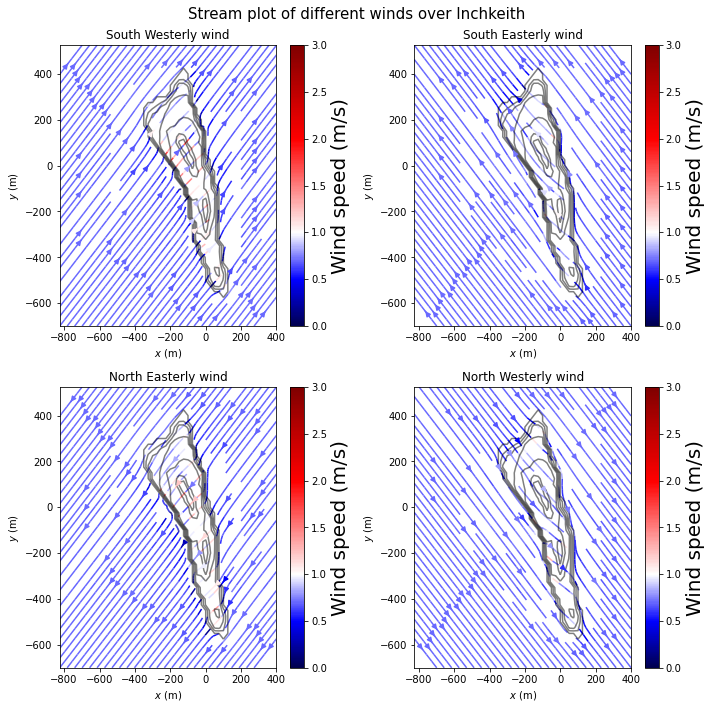

In [22]:
# South Westerly wind
plt.subplot(221)
plot_wind(usw, vsw, windsw, z, 'South Westerly wind')

# South Easterly wind
plt.subplot(222)
plot_wind(use, vse, windse, z, 'South Easterly wind')

# North Easterly wind
plt.subplot(223)
plot_wind(une, vne, windne, z, 'North Easterly wind')

# North Westerly wind
plt.subplot(224)
plot_wind(unw, vnw, windnw, z, 'North Westerly wind')

plt.suptitle("Stream plot of different winds over Inchkeith", fontsize = 15)
plt.tight_layout()

'''Not sure what the blue arrows are?'''

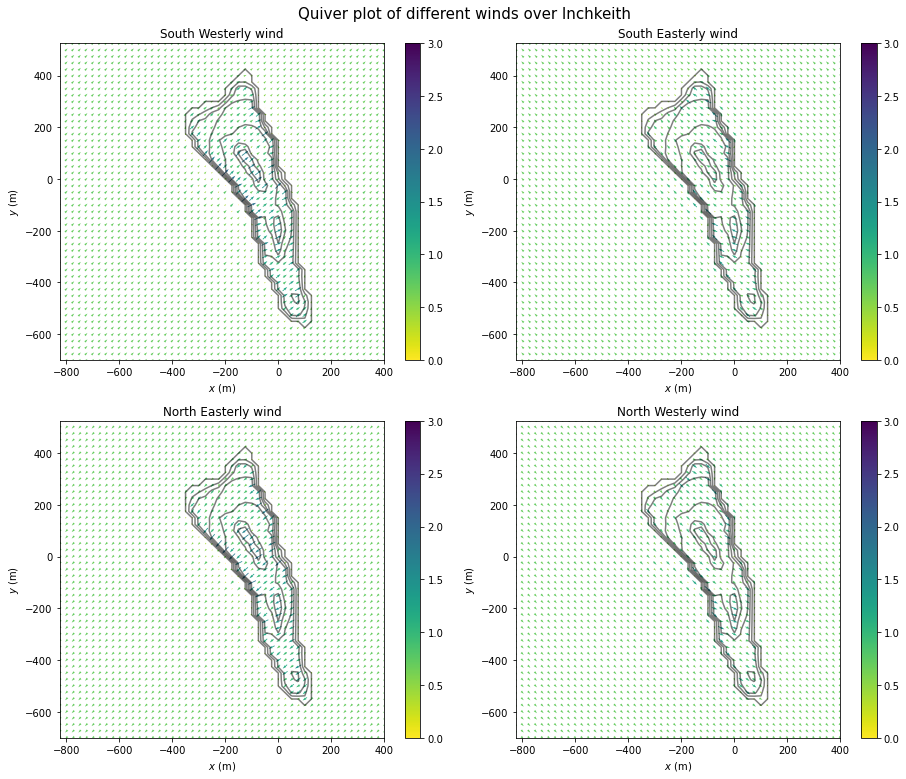

In [23]:
plt.figure(figsize=(13, 11))

# South Westerly wind
plt.subplot(221)
quiver_wind(usw,vsw,windsw,z,'South Westerly wind')

# South Easterly wind
plt.subplot(222)
quiver_wind(use,vse,windse,z,'South Easterly wind')

# North Easterly wind
plt.subplot(223)
quiver_wind(une,vne,windne,z,'North Easterly wind')

# North Westerly wind
plt.subplot(224)
quiver_wind(unw,vnw,windnw,z,'North Westerly wind')

plt.suptitle("Quiver plot of different winds over Inchkeith", fontsize = 15)
plt.tight_layout()